## OVERVIEW
---
* Time Series Data Visualization and Feature Extraction.
* Autocorrelation Function and Partial Autocorrelation Function Comparison.
* Seasonal Decompose of Time Series Data.
* Monte Carlo Simulation for Bitcoin Price for the Next 30 Days.
* Forecasting Bitcoin Price by Using Classical Stats Method.

In [84]:
#VIZ LIBRARY
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm as tqdm
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')
import plotly_express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots


#CLASSICAL STATS
import scipy
import statsmodels
from scipy import signal
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from fbprophet import Prophet
from scipy.signal import butter, deconvolve
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import SimpleExpSmoothing, Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

#METRICS
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report, r2_score,mean_absolute_error,mean_squared_error


import warnings 
warnings.filterwarnings('ignore')

In [52]:
#read the data
df = pd.read_csv('data/coinbaseUSD_1-min_data_2014-12-01_to_2019-01-09.csv')

In [53]:
#convert date to pandas datetime object
df['date'] = pd.to_datetime(df['Timestamp'], unit='s').dt.date

#getting the real price of bitcoin
real_price = df.groupby('date')['Weighted_Price'].mean()
bitcoin_df = pd.DataFrame(data = real_price)
bitcoin_df = bitcoin_df.reset_index()
bitcoin_df.columns = ['date', 'price']

## DATA BASIC INFORMATION
---

In [54]:
#show dataframe
bitcoin_df.T

,0,1,2,3,4,5,6,7,8,9,...,1455,1456,1457,1458,1459,1460,1461,1462,1463,1464
date,2014-12-01,2014-12-02,2014-12-03,2014-12-04,2014-12-06,2014-12-08,2014-12-10,2014-12-12,2014-12-18,2015-01-08,...,2018-12-29,2018-12-30,2018-12-31,2019-01-01,2019-01-02,2019-01-03,2019-01-04,2019-01-05,2019-01-06,2019-01-07
price,335,377.855,377.818,377.1,378,375,379.25,363.611,342.5,295.068,...,3874.1,3788.86,3756.54,3700.54,3823.15,3829.9,3785.34,3834.57,3874.34,4025.02


In [55]:
#show features data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2099760 entries, 0 to 2099759
Data columns (total 9 columns):
Timestamp            int64
Open                 float64
High                 float64
Low                  float64
Close                float64
Volume_(BTC)         float64
Volume_(Currency)    float64
Weighted_Price       float64
date                 object
dtypes: float64(7), int64(1), object(1)
memory usage: 144.2+ MB


In [56]:
print('DATASET SHAPE: ', df.shape)

DATASET SHAPE:  (2099760, 9)


In [57]:
#get basic statistical info of the data
bitcoin_df.describe().T

,count,mean,std,min,25%,50%,75%,max
price,1465.0,3093.900935,3752.150281,156.175582,399.296575,898.315693,6214.307813,19537.276941


## EDA
---

#### TIME SERIES PLOT OF BITCOIN PRICE

Text(0, 0.5, 'Price')

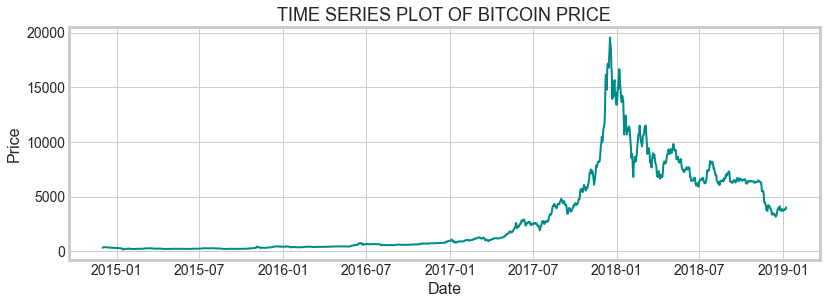

In [58]:
# fig show
plt.figure(figsize=(12,4))
sns.lineplot(x = bitcoin_df.date, y = bitcoin_df.price, lw=2, color='darkcyan')
plt.title('TIME SERIES PLOT OF BITCOIN PRICE', fontsize=18)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Price', fontsize=16)

* Bitcoin price started to grow exponentially at year 2017.

#### SNIPPET GRAPH OF PRICE FOR THE LAST 30 DAYS

Text(0, 0.5, 'Price')

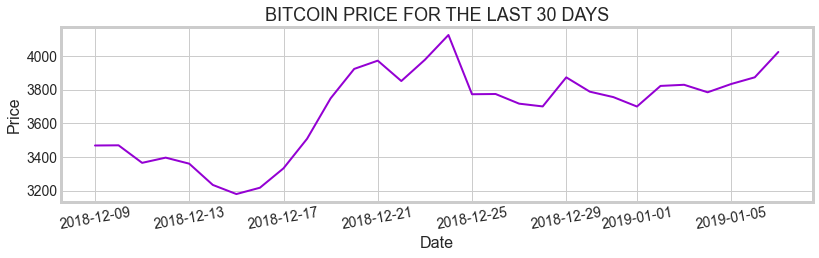

In [109]:
#show fig
plt.figure(figsize=(12,3))
plt.xticks(rotation=10)
sns.lineplot(x = bitcoin_df['date'][-30:], y = bitcoin_df['price'][-30:], lw=2, color='darkviolet')
plt.title('BITCOIN PRICE FOR THE LAST 30 DAYS', fontsize=18)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Price', fontsize=16)


#### AUTOCORELATION FUNCTION (LAG = 10)

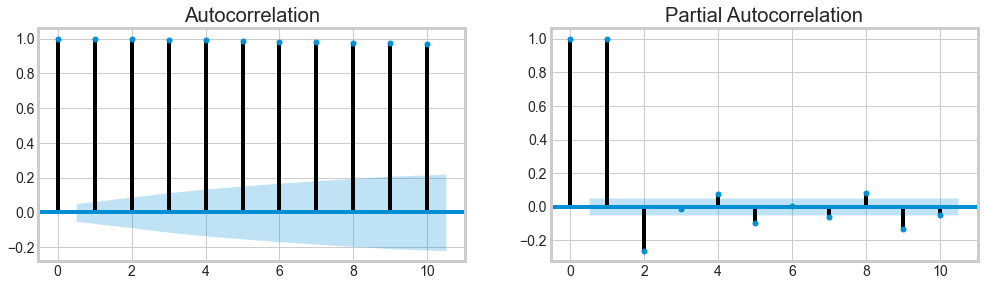

In [65]:
#plot ACF
fig, ax = plt.subplots(1,2, figsize=(15,4))
plot_acf(bitcoin_df.price, lags=10, ax=ax[0])
plot_pacf(bitcoin_df.price, lags=10, ax=ax[1])
plt.show()

* The autocorrelation function shows a veryslow decay, which means that the future values have a very high correlation with its past values.

* The partial autocorrelation function shows a high correlation with the first lag and lesser correlation with the second and third lag. 

#### SEASONAL DECOMPOSITION

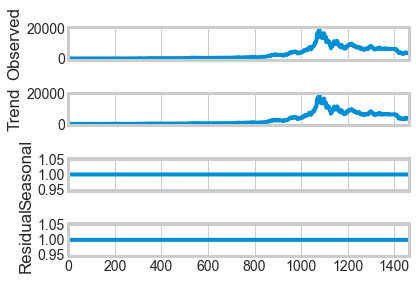

In [100]:
result  = seasonal_decompose(bitcoin_df.price, model='multiplicative', freq=1)
result.plot()
plt.show()

* We can see that the residual plot shows zero. The decomposition was not able to separate the noise that we added from the linear trend.

## FORECASTING (CLASSICAL STATATISTICS METHOD)
---

In [146]:
df_train = bitcoin_df[:-30]
df_test = bitcoin_df[-30:]

### NAIVE APPROACH
---

In [147]:
predictions = []

for i in range(len(df_test.date)):
    
    if i == 0:
        predictions.append(df_train['price'].values[-1])
    else:
        predictions.append(df_test['price'].values[i-1])
        
predictions = np.transpose(np.array([row.tolist() for row in predictions]))

Text(0, 0.5, 'Price')

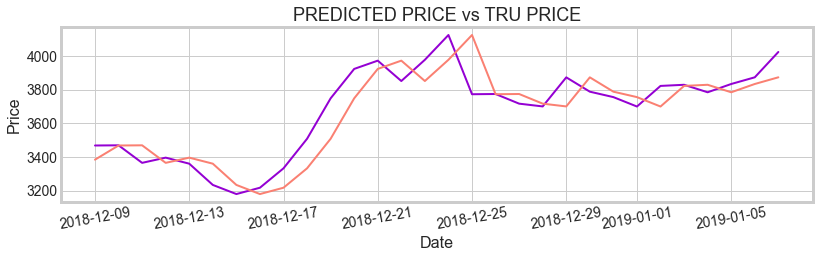

In [148]:
#show fig
plt.figure(figsize=(12,3))
plt.xticks(rotation=10)
sns.lineplot(x = df_test['date'], y = df_test['price'], lw=2, color='darkviolet')
sns.lineplot(x = df_test['date'], y = predictions, lw=2, color='salmon')

plt.title('PREDICTED PRICE vs TRU PRICE', fontsize=18)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Price', fontsize=16)


In [149]:
nb_error_rate = abs(((df_test.price.values - predictions) / df_test.price.values).mean()) * 100
print('MAPE: ', round(nb_error_rate,2), '%')

MAPE:  0.53 %


In [150]:
nb_mae = mean_absolute_error(predictions, df_test.price.values)
nb_mse = mean_squared_error(predictions, df_test.price.values)
nb_rmse = np.sqrt(mean_squared_error(predictions, df_test.price.values))

print('Mean Absolute Error:   ', nb_mae)
print('Mean Squared Error:   ', nb_mse)
print('Root Mean Squared Error:   ', nb_rmse)

Mean Absolute Error:    93.79345920781715
Mean Squared Error:    14700.643747052169
Root Mean Squared Error:    121.24621126885643


### MOVING AVERAGE METHOD
---

In [151]:
predictions = []
for i in range(len(df_test.date)):
    if i == 0:
        predictions.append(np.mean(df_train['price'][-30:].values))
    if i < (len(df_test.price)+1) and i > 0:
        predictions.append(0.5 * (np.mean(df_train['price'][-30+i:].values) + \
                                  np.mean(predictions[:i])))
    if i > (len(df_test.price)+1):
        predictions.append(np.mean(predictions))

In [152]:
predictions = np.transpose(np.array([row.tolist() for row in predictions]))

Text(0, 0.5, 'Price')

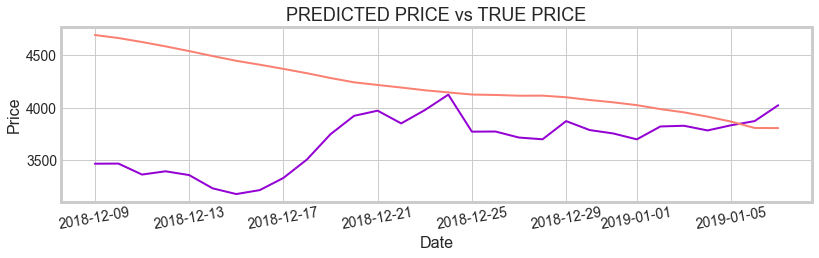

In [153]:
#show fig
plt.figure(figsize=(12,3))
plt.xticks(rotation=10)
sns.lineplot(x = df_test['date'], y = df_test['price'], lw=2, color='darkviolet')
sns.lineplot(x = df_test['date'], y = predictions, lw=2, color='salmon')

plt.title('PREDICTED PRICE vs TRUE PRICE', fontsize=18)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Price', fontsize=16)


In [154]:
mave_error_rate = abs(((df_test.price.values - predictions) / df_test.price.values).mean()) * 100
print('MAPE: ', round(mave_error_rate,2), '%')

MAPE:  15.54 %


In [155]:
mave_mae = mean_absolute_error(predictions, df_test.price.values)
mave_mse = mean_squared_error(predictions, df_test.price.values)
mave_rmse = np.sqrt(mean_squared_error(predictions, df_test.price.values))

print('Mean Absolute Error:   ', mave_mae)
print('Mean Squared Error:   ', mave_mse)
print('Root Mean Squared Error:   ', mave_rmse)

Mean Absolute Error:    555.8210831911916
Mean Squared Error:    510577.08270188636
Root Mean Squared Error:    714.5467673300932


### HOLTLINEAR
----

In [156]:
predictions = []

fit = Holt(np.asarray(df_train['price'][-30:])).fit(smoothing_level = 0.1,smoothing_slope = 0.01)
predictions = fit.forecast(len(df_test.price))

Text(0, 0.5, 'Price')

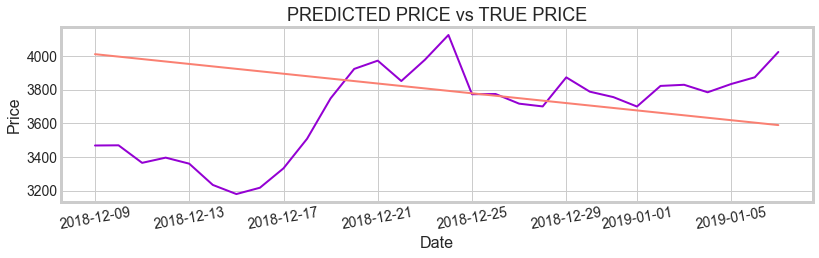

In [157]:
#show fig
plt.figure(figsize=(12,3))
plt.xticks(rotation=10)
sns.lineplot(x = df_test['date'], y = df_test['price'], lw=2, color='darkviolet')
sns.lineplot(x = df_test['date'], y = predictions, lw=2, color='salmon')

plt.title('PREDICTED PRICE vs TRUE PRICE', fontsize=18)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Price', fontsize=16)


In [158]:
ht_error_rate = abs(((df_test.price.values - predictions) / df_test.price.values).mean()) * 100
print('MAPE:', round(ht_error_rate,2), '%')

MAPE: 3.99 %


In [159]:
ht_mae = mean_absolute_error(predictions, df_test.price.values)
ht_mse = mean_squared_error(predictions, df_test.price.values)
ht_rmse = np.sqrt(mean_squared_error(predictions, df_test.price.values))

print('Mean Absolute Error:   ', ht_mae)
print('Mean Squared Error:   ', ht_mse)
print('Root Mean Squared Error:   ', ht_rmse)

Mean Absolute Error:    286.9598380313562
Mean Squared Error:    140883.52720141326
Root Mean Squared Error:    375.34454465385966


### HOLT-WINTER (EXPONENTIAL SMOOTHING)
---

In [160]:
predictions = []

fit = ExponentialSmoothing(np.asarray(df_train.price) ,seasonal_periods=7,trend='add', seasonal='add',).fit()
predictions = fit.forecast(len(df_test.price))

Text(0, 0.5, 'Price')

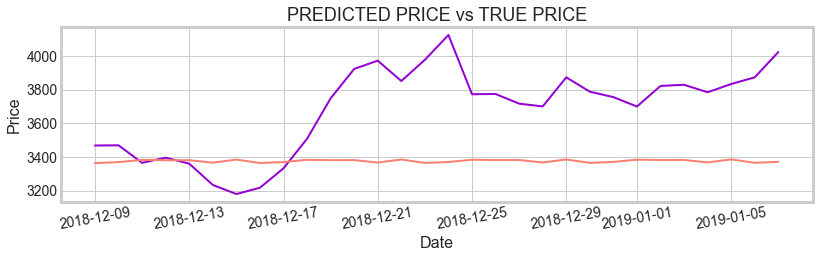

In [161]:
#show fig
plt.figure(figsize=(12,3))
plt.xticks(rotation=10)
sns.lineplot(x = df_test['date'], y = df_test['price'], lw=2, color='darkviolet')
sns.lineplot(x = df_test['date'], y = predictions, lw=2, color='salmon')

plt.title('PREDICTED PRICE vs TRUE PRICE', fontsize=18)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Price', fontsize=16)


In [162]:
hw_error_rate = abs(((df_test.price.values - predictions) / df_test.price.values).mean()) * 100
print('MAPE:', round(hw_error_rate,2), '%')

MAPE: 7.8 %


In [163]:
hw_mae = mean_absolute_error(predictions, df_test.price.values)
hw_mse = mean_squared_error(predictions, df_test.price.values)
hw_rmse = np.sqrt(mean_squared_error(predictions, df_test.price.values))

print('Mean Absolute Error:   ', hw_mae)
print('Mean Squared Error:   ', hw_mse)
print('Root Mean Squared Error:   ', hw_rmse)

Mean Absolute Error:    341.35017591279785
Mean Squared Error:    157848.74334800063
Root Mean Squared Error:    397.30182902674966


### ARIMA
---

In [164]:
predictions = []
fit = sm.tsa.statespace.SARIMAX(df_train.price[-30:].values, order=(1, 0, 0),seasonal_order=(0, 1, 1, 7)).fit()
predictions.append(fit.forecast(30))
predictions = np.array(predictions).reshape((30, ))

Text(0, 0.5, 'Price')

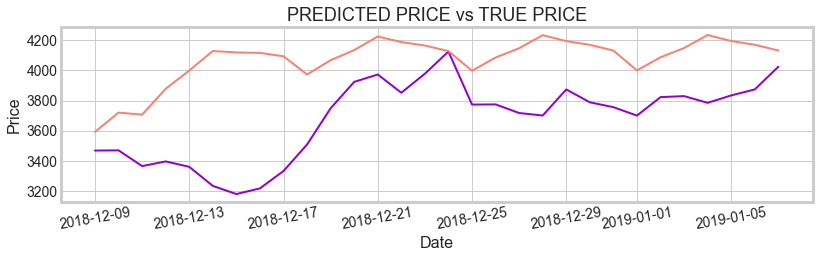

In [165]:
#show fig
plt.figure(figsize=(12,3))
plt.xticks(rotation=10)
sns.lineplot(x = df_test['date'], y = df_test['price'], lw=2, color='darkviolet')
sns.lineplot(x = df_test['date'], y = predictions, lw=2, color='salmon')

plt.title('PREDICTED PRICE vs TRUE PRICE', fontsize=18)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Price', fontsize=16)


In [166]:
arima_error_rate = abs(((df_test.price.values - predictions) / df_test.price.values).mean()) * 100
print('MAPE:', round(arima_error_rate,2), '%')

MAPE: 11.09 %


In [167]:
arima_mae = mean_absolute_error(predictions, df_test.price.values)
arima_mse = mean_squared_error(predictions, df_test.price.values)
arima_rmse = np.sqrt(mean_squared_error(predictions, df_test.price.values))

print('Mean Absolute Error:   ', arima_mae)
print('Mean Squared Error:   ', arima_mse)
print('Root Mean Squared Error:   ', arima_rmse)

Mean Absolute Error:    392.7553271072802
Mean Squared Error:    206119.81043164458
Root Mean Squared Error:    454.00419649122693


### FBPROPHET
---

In [168]:

predictions = []
dates = df_train.date[-30:]
data = df_train.price[-30:].values

df = pd.DataFrame()
df['ds'], df['y'] = df_test.date,data.tolist()
model = Prophet(daily_seasonality=True)
model.fit(df)
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)["yhat"].loc[30:].values
predictions.append(forecast)
predictions = np.array(predictions).reshape(30,)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.


Text(0, 0.5, 'Price')

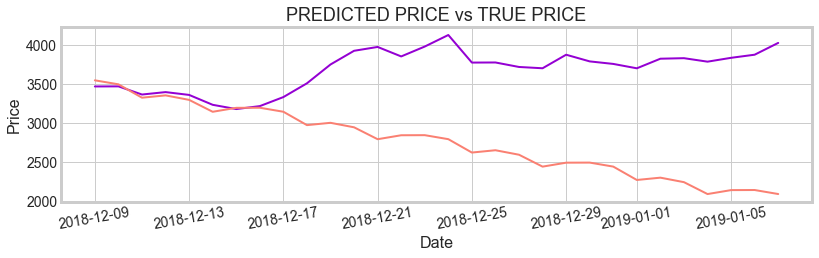

In [169]:
#show fig
plt.figure(figsize=(12,3))
plt.xticks(rotation=10)
sns.lineplot(x = df_test['date'], y = df_test['price'], lw=2, color='darkviolet')
sns.lineplot(x = df_test['date'], y = predictions, lw=2, color='salmon')

plt.title('PREDICTED PRICE vs TRUE PRICE', fontsize=18)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Price', fontsize=16)


In [170]:
fb_error_rate = abs(((df_test.price.values - predictions) / df_test.price.values).mean()) * 100
print('MAPE:', round(fb_error_rate,2), '%')

MAPE: 23.88 %


In [171]:
fb_mae = mean_absolute_error(predictions, df_test.price.values)
fb_mse = mean_squared_error(predictions, df_test.price.values)
fb_rmse = np.sqrt(mean_squared_error(predictions, df_test.price.values))

print('Mean Absolute Error:   ', fb_mae)
print('Mean Squared Error:   ', fb_mse)
print('Root Mean Squared Error:   ', fb_rmse)

Mean Absolute Error:    922.5354031146916
Mean Squared Error:    1243887.9431874955
Root Mean Squared Error:    1115.2972443198698


### MODEL COMPARISON BY MAPE

In [172]:
models = ['NAIVE APPROACH', 'MOVING AVE.', 'HOLT-LINEAR', 'HOLT-WINTER',
          'ARIMA', 'FBPROPHET']

err_rate = [nb_error_rate, mave_error_rate, ht_error_rate, hw_error_rate,
            arima_error_rate, fb_error_rate]
err_rate = [round(err,2) for err in err_rate]

Text(0, 0.5, 'MAPE')

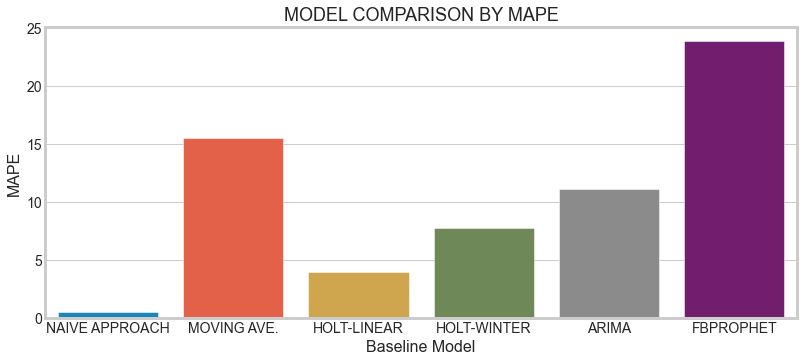

In [180]:
#show fig
plt.figure(figsize=(12,5))
sns.barplot(x = models, y = err_rate, )
plt.title('MODEL COMPARISON BY MAPE', fontsize=18)
plt.xlabel('Baseline Model', fontsize=16)
plt.ylabel('MAPE', fontsize=16)


### MONTE CARLO SIMULATION OF BITCOIN PRICE FOR THE NEXT 30 DAYS
---

In [204]:
#function that can generate a monte carlo simulation    
def monte_carlo_simulation(data,t_intervals ,iteration , figsize = (10,4), lw=1):
    from scipy.stats import norm

    #log returns of data
    log_returns = np.log(1 + data.pct_change())

    #Setting up the drift and random component
    mean_  = log_returns.mean()
    var = log_returns.var()
    stdev = log_returns.std()
    drift = mean_ - (0.5 *var)

    daily_returns = np.exp(drift + stdev * norm.ppf(np.random.rand(t_intervals, iteration)))

    S0 = data.iloc[-1]
    #Empty daily returns
    price_list = np.zeros_like(daily_returns)
    price_list[0] = S0

    #appliying montecarlo simulation
    for i in range(1 , t_intervals):
        price_list[i] = price_list[i-1] * daily_returns[i]
    fig_title = str(t_intervals)+ ' DAYS SIMULATION WITH ' +str(iteration)+' DIFFERENT POSSIBILITIES'
    #Show the result of 30 days simulation
    plt.figure(figsize=figsize)
    plt.plot(price_list, lw=lw)
    plt.title(fig_title)
    plt.xlabel('Interval', fontsize=16)
    plt.ylabel('Value', fontsize=16)

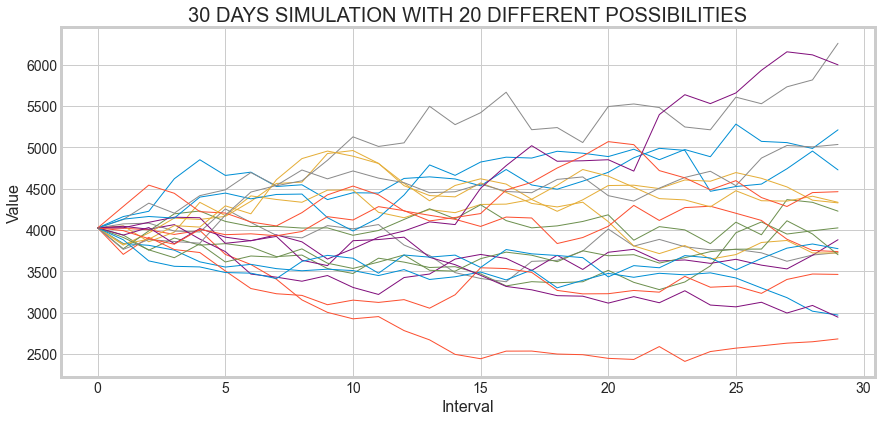

In [205]:
#show the figure
monte_carlo_simulation(bitcoin_df.price,30,20, figsize=(13,6))